In [1]:
import numpy as np
from numpy import array
import pandas as pd
import sqlite3

from sklearn.feature_extraction import DictVectorizer
from sklearn import mixture
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import sklearn.metrics as metrics
import sklearn.manifold

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from pylab import plot, show

database = 'database.sqlite'
conn = sqlite3.connect(database)

query = "SELECT name FROM sqlite_master WHERE type='table';"
pd.read_sql(query, conn)

,name
0,sqlite_sequence
1,Player_Attributes
2,Player
3,Match
4,League
5,Country
6,Team
7,Team_Attributes


In [2]:
query = """SELECT * FROM Player_Attributes a
           INNER JOIN (SELECT player_name, player_api_id AS p_id FROM Player) b ON a.player_api_id = b.p_id;"""

drop_cols = ['id','player_fifa_api_id','date','preferred_foot',
             'attacking_work_rate','defensive_work_rate']

players_ready = pd.read_sql(query, conn)
players_ready = players_ready.drop_duplicates(subset='player_api_id', keep='first')
players_ready = players_ready.drop(drop_cols, axis=1)
players_ready.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11060 entries, 0 to 183968
Data columns (total 38 columns):
player_api_id         11060 non-null int64
overall_rating        11060 non-null float64
potential             11060 non-null float64
crossing              11060 non-null float64
finishing             11060 non-null float64
heading_accuracy      11060 non-null float64
short_passing         11060 non-null float64
volleys               10582 non-null float64
dribbling             11060 non-null float64
curve                 10582 non-null float64
free_kick_accuracy    11060 non-null float64
long_passing          11060 non-null float64
ball_control          11060 non-null float64
acceleration          11060 non-null float64
sprint_speed          11060 non-null float64
agility               10582 non-null float64
reactions             11060 non-null float64
balance               10582 non-null float64
shot_power            11060 non-null float64
jumping               10582 non-null 

In [3]:
players_ready.isnull().sum(axis=0)

player_api_id           0
overall_rating          0
potential               0
crossing                0
finishing               0
heading_accuracy        0
short_passing           0
volleys               478
dribbling               0
curve                 478
free_kick_accuracy      0
long_passing            0
ball_control            0
acceleration            0
sprint_speed            0
agility               478
reactions               0
balance               478
shot_power              0
jumping               478
stamina                 0
strength                0
long_shots              0
aggression              0
interceptions           0
positioning             0
vision                478
penalties               0
marking                 0
standing_tackle         0
sliding_tackle        478
gk_diving               0
gk_handling             0
gk_kicking              0
gk_positioning          0
gk_reflexes             0
player_name             0
p_id                    0
dtype: int64

In [6]:
rows = players_ready.shape[0]

# Drop the NULL rows
players_ready = players_ready.dropna()
print(rows)
players_ready.isnull().any().any(), players_ready.shape

10582


(False, (10582, 38))

In [7]:
players_ready.isnull().sum(axis=0)

player_api_id         0
overall_rating        0
potential             0
crossing              0
finishing             0
heading_accuracy      0
short_passing         0
volleys               0
dribbling             0
curve                 0
free_kick_accuracy    0
long_passing          0
ball_control          0
acceleration          0
sprint_speed          0
agility               0
reactions             0
balance               0
shot_power            0
jumping               0
stamina               0
strength              0
long_shots            0
aggression            0
interceptions         0
positioning           0
vision                0
penalties             0
marking               0
standing_tackle       0
sliding_tackle        0
gk_diving             0
gk_handling           0
gk_kicking            0
gk_positioning        0
gk_reflexes           0
player_name           0
p_id                  0
dtype: int64

In [8]:
cols = ['potential',  'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes']
correlations = [players_ready['overall_rating'].corr(players_ready[f]) for f in cols ]
print(len(cols)==len(correlations))

True


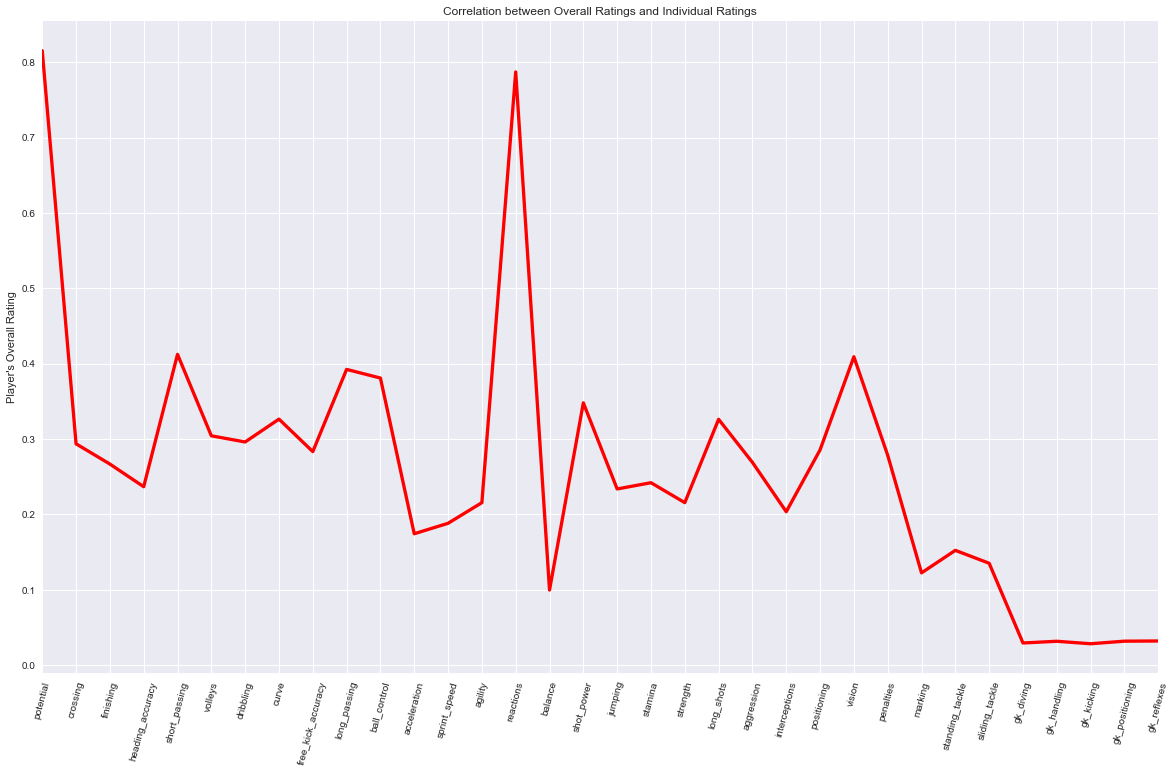

In [177]:
def plot_dataframe(df, y_label):  
    color='red'
    fig = plt.gcf()
    fig.set_size_inches(20, 12)
    plt.ylabel(y_label)

    ax = df2.correlation.plot(linewidth=3.3, color=color)
    ax.set_xticks(df2.index)
    ax.set_xticklabels(df2.attributes, rotation=75); #Notice the ; (remove it and see what happens !)
    plt.title('Correlation between Overall Ratings and Individual Ratings')
    plt.show()

df2 = pd.DataFrame({'attributes': cols, 'correlation': correlations}) 
plot_dataframe(df2, 'Player\'s Overall Rating')

In [14]:

player_stats = pd.DataFrame(players_ready)
player_stats=player_stats.drop(['player_api_id','overall_rating','potential','player_name', 'p_id'], axis=1)
player_stats.head()


,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
5,80.0,53.0,58.0,71.0,40.0,73.0,70.0,69.0,68.0,71.0,...,66.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
38,64.0,58.0,60.0,66.0,52.0,66.0,67.0,63.0,62.0,67.0,...,68.0,61.0,23.0,22.0,24.0,16.0,11.0,12.0,9.0,13.0
64,57.0,21.0,68.0,65.0,48.0,56.0,38.0,40.0,61.0,62.0,...,54.0,37.0,72.0,71.0,68.0,15.0,12.0,13.0,12.0,11.0
87,46.0,34.0,73.0,65.0,33.0,47.0,42.0,25.0,58.0,58.0,...,41.0,45.0,75.0,73.0,71.0,8.0,6.0,16.0,12.0,11.0


In [16]:
# Number of clusters
kstats = KMeans(n_clusters=4)
# Fitting the input data
kstats = kstats.fit(player_stats)
# Getting the cluster labels
kstats_label = kstats.predict(player_stats)
print(kstats_label)
df_stats = pd.DataFrame(kstats_label)
df_stats.head()

[1 3 2 ..., 3 1 2]


,0
0,1
1,3
2,2
3,1
4,1


In [100]:
df_stats.columns=['position']
df_stats.tail(1000)
#df_stats.isnull().sum(axis=0)

,position
9582,1
9583,1
9584,2
9585,2
9586,2
9587,2
9588,2
9589,2
9590,2
9591,2


In [96]:
new_df = players_ready.join(df_stats)


In [105]:

players_ready.isnull().sum(axis=0)
players_ready = players_ready.reset_index()


ValueError: cannot insert level_0, already exists

In [109]:
players_ready=players_ready.drop("index",1)
players_ready=players_ready.drop("level_0",1)


ValueError: labels ['index'] not contained in axis

In [111]:
players_ready['cluster'] = df_stats
players_ready.head()

,player_api_id,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,...,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name,p_id,cluster
0,505942,67.0,71.0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,...,69.0,69.0,6.0,11.0,10.0,8.0,8.0,Aaron Appindangoye,505942,1
1,155782,74.0,76.0,80.0,53.0,58.0,71.0,40.0,73.0,70.0,...,75.0,78.0,14.0,7.0,9.0,9.0,12.0,Aaron Cresswell,155782,3
2,162549,65.0,67.0,64.0,58.0,60.0,66.0,52.0,66.0,67.0,...,22.0,24.0,16.0,11.0,12.0,9.0,13.0,Aaron Doran,162549,2
3,30572,69.0,69.0,57.0,21.0,68.0,65.0,48.0,56.0,38.0,...,71.0,68.0,15.0,12.0,13.0,12.0,11.0,Aaron Galindo,30572,1
4,23780,70.0,70.0,46.0,34.0,73.0,65.0,33.0,47.0,42.0,...,73.0,71.0,8.0,6.0,16.0,12.0,11.0,Aaron Hughes,23780,1


In [122]:
players_ready.isnull().sum(axis=0)

player_api_id         0
overall_rating        0
potential             0
crossing              0
finishing             0
heading_accuracy      0
short_passing         0
volleys               0
dribbling             0
curve                 0
free_kick_accuracy    0
long_passing          0
ball_control          0
acceleration          0
sprint_speed          0
agility               0
reactions             0
balance               0
shot_power            0
jumping               0
stamina               0
strength              0
long_shots            0
aggression            0
interceptions         0
positioning           0
vision                0
penalties             0
marking               0
standing_tackle       0
sliding_tackle        0
gk_diving             0
gk_handling           0
gk_kicking            0
gk_positioning        0
gk_reflexes           0
player_name           0
p_id                  0
cluster               0
dtype: int64

In [112]:
new_df.isnull().sum(axis=0)

player_api_id            0
overall_rating           0
potential                0
crossing                 0
finishing                0
heading_accuracy         0
short_passing            0
volleys                  0
dribbling                0
curve                    0
free_kick_accuracy       0
long_passing             0
ball_control             0
acceleration             0
sprint_speed             0
agility                  0
reactions                0
balance                  0
shot_power               0
jumping                  0
stamina                  0
strength                 0
long_shots               0
aggression               0
interceptions            0
positioning              0
vision                   0
penalties                0
marking                  0
standing_tackle          0
sliding_tackle           0
gk_diving                0
gk_handling              0
gk_kicking               0
gk_positioning           0
gk_reflexes              0
player_name              0
p

In [124]:
new_df = players_ready.sort_values(by=['cluster'])
#print(len(new_df'0')))
new_df.head()


,player_api_id,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,...,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name,p_id,cluster
1246,39725,70.0,70.0,19.0,10.0,11.0,26.0,10.0,18.0,14.0,...,19.0,13.0,68.0,66.0,74.0,76.0,71.0,Bogdan Lobont,39725,0
4424,177126,82.0,86.0,13.0,11.0,15.0,29.0,13.0,12.0,13.0,...,12.0,18.0,79.0,84.0,73.0,84.0,83.0,Jan Oblak,177126,0
4423,24341,68.0,68.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,...,25.0,25.0,71.0,68.0,63.0,62.0,73.0,Jan Mucha,24341,0
6451,212630,78.0,83.0,13.0,18.0,18.0,32.0,12.0,19.0,14.0,...,17.0,13.0,84.0,72.0,70.0,76.0,86.0,Marco Sportiello,212630,0
6452,27615,75.0,75.0,14.0,12.0,21.0,32.0,12.0,21.0,11.0,...,14.0,11.0,78.0,72.0,66.0,76.0,78.0,Marco Storari,27615,0


In [167]:
new_df.tail(20)

,player_api_id,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,...,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name,p_id,cluster
7515,265913,69.0,74.0,63.0,59.0,57.0,71.0,61.0,76.0,70.0,...,62.0,49.0,9.0,8.0,15.0,8.0,6.0,Nene Bonilha,265913,3
3243,181203,74.0,80.0,55.0,50.0,73.0,78.0,55.0,59.0,59.0,...,76.0,68.0,7.0,16.0,11.0,11.0,7.0,Flavio Nunes Ferreira,181203,3
3242,11897,70.0,73.0,56.0,51.0,68.0,67.0,51.0,61.0,50.0,...,66.0,62.0,11.0,6.0,14.0,14.0,15.0,Flavio Meireles,11897,3
3785,32734,74.0,74.0,75.0,64.0,69.0,78.0,69.0,75.0,77.0,...,64.0,60.0,7.0,6.0,11.0,6.0,11.0,Graham Dorrans,32734,3
3237,74305,70.0,70.0,65.0,44.0,57.0,75.0,42.0,65.0,53.0,...,63.0,59.0,9.0,15.0,7.0,5.0,11.0,Filippo Porcari,74305,3
7527,97326,65.0,65.0,68.0,39.0,58.0,67.0,46.0,69.0,51.0,...,68.0,66.0,11.0,7.0,11.0,7.0,8.0,Ney Santos,97326,3
3231,23986,65.0,75.0,66.0,61.0,56.0,64.0,63.0,63.0,52.0,...,68.0,68.0,6.0,9.0,5.0,11.0,15.0,Filipe Oliveira,23986,3
3228,41167,82.0,82.0,82.0,59.0,66.0,75.0,56.0,77.0,74.0,...,82.0,85.0,11.0,15.0,9.0,9.0,5.0,Filipe Luis,41167,3
3227,149949,69.0,69.0,61.0,59.0,62.0,74.0,59.0,68.0,61.0,...,66.0,57.0,16.0,14.0,6.0,12.0,12.0,Filipe Goncalves,149949,3
3226,476766,71.0,72.0,66.0,48.0,56.0,71.0,40.0,70.0,61.0,...,71.0,70.0,6.0,9.0,14.0,15.0,13.0,Filipe Ferreira,476766,3


In [126]:
pos_0 = new_df.cluster == 0.0
group_0 = new_df[pos_0]

pos_1 = new_df.cluster == 1.0
group_1 = new_df[pos_1]


pos_2 = new_df.cluster == 2.0
group_2 = new_df[pos_2]


pos_3 = new_df.cluster == 3.0
group_3 = new_df[pos_3]


In [130]:
print(len(group_3))

3230


In [131]:

lst_0 = []
lst_1 = []
lst_2 = []
lst_3 = []
for elem in cols:
    lst_0.append(group_0[elem].mean())
    lst_1.append(group_1[elem].mean())
    lst_2.append(group_2[elem].mean())
    lst_3.append(group_3[elem].mean())


In [132]:
average_0 = pd.DataFrame(lst_0)
average_0 = average_0.transpose()
average_0.columns=cols


average_1 = pd.DataFrame(lst_1)
average_1 = average_1.transpose()
average_1.columns=cols


average_2 = pd.DataFrame(lst_2)
average_2 = average_2.transpose()
average_2.columns=cols


average_3 = pd.DataFrame(lst_3)
average_3 = average_3.transpose()
average_3.columns=cols


In [119]:
print(average_0.iloc[0])

potential             71.509434
crossing              57.094340
finishing             50.113208
heading_accuracy      58.433962
short_passing         65.000000
volleys               48.283019
dribbling             61.792453
curve                 55.075472
free_kick_accuracy    50.075472
long_passing          59.320755
ball_control          65.320755
acceleration          67.132075
sprint_speed          67.622642
agility               66.056604
reactions             65.849057
balance               64.433962
shot_power            61.792453
jumping               65.735849
stamina               67.226415
strength              68.433962
long_shots            54.603774
aggression            63.283019
interceptions         53.716981
positioning           53.641509
vision                59.113208
penalties             54.471698
marking               49.962264
standing_tackle       53.339623
sliding_tackle        50.962264
gk_diving             12.716981
gk_handling           12.471698
gk_kicki

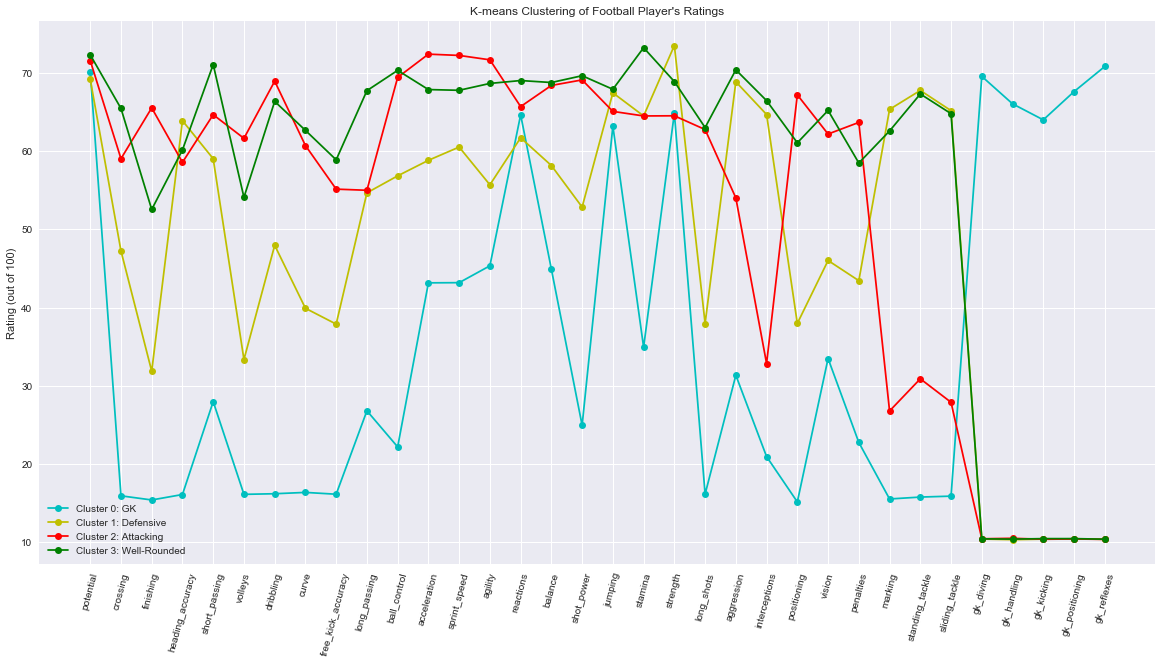

In [176]:
from matplotlib.ticker import FuncFormatter, MaxNLocator
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)

xs = range(len(lst_0))

def format_fn(tick_val, tick_pos):
    if int(tick_val) in xs:
        return cols[int(tick_val)]
    else:
        return ''


# ax1.xaxis.set_major_formatter(FuncFormatter(format_fn))
# ax1.xaxis.set_ticks(np.arange(0, 30))
# ax1.xaxis.set_major_locator(MaxNLocator(integer=True))


ax1.set_xticks(range(0,34))
ax1.set_xticklabels(cols, rotation=75); #Notice the ; (remove it and see what happens !)


ax1.plot(lst_0, color='c', label="Cluster 0: GK",marker='o')
ax1.plot(lst_1, color='y', label="Cluster 1: Defensive",marker='o')
ax1.plot(lst_2, color='r', label="Cluster 2: Attacking",marker='o')
ax1.plot(lst_3, color='g', label="Cluster 3: Well-Rounded",marker='o')
plt.legend(loc='best')
plt.title("K-means Clustering of Football Player's Ratings")
plt.ylabel('Rating (out of 100)')
plt.show()

In [121]:
group_3.describe()

,player_api_id,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,...,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,p_id,cluster,position
count,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,...,180.000000,180.000000,180.000000,180.000000,180.000000,180.00000,180.000000,180.000000,180.0,180.0
mean,208178.627778,68.522222,72.000000,53.855556,47.683333,56.227778,62.038889,47.444444,58.827778,53.138889,...,50.011111,47.905556,15.538889,15.500000,15.150000,16.15000,16.072222,208178.627778,3.0,3.0
std,191404.071619,5.725036,5.878661,17.571600,18.796611,17.415985,14.325180,17.605935,18.524883,18.355205,...,22.657515,22.371594,16.964427,16.407009,15.983048,16.85312,17.454820,191404.071619,0.0,0.0
min,2790.000000,50.000000,55.000000,6.000000,3.000000,8.000000,11.000000,6.000000,7.000000,6.000000,...,8.000000,5.000000,4.000000,5.000000,4.000000,4.00000,5.000000,2790.000000,3.0,3.0
25%,39334.250000,65.000000,68.000000,43.000000,33.000000,47.750000,58.000000,35.000000,49.750000,41.000000,...,27.000000,25.000000,8.000000,8.000000,8.000000,8.00000,8.000000,39334.250000,3.0,3.0
50%,160333.500000,69.000000,72.000000,58.000000,51.500000,60.000000,65.000000,49.500000,64.500000,57.000000,...,60.000000,54.500000,10.000000,11.000000,10.500000,12.00000,12.000000,160333.500000,3.0,3.0
75%,293641.000000,72.250000,76.000000,67.000000,62.000000,68.000000,71.000000,62.000000,72.000000,67.000000,...,70.000000,68.000000,14.000000,14.000000,14.000000,14.00000,14.000000,293641.000000,3.0,3.0
max,750584.000000,82.000000,86.000000,86.000000,82.000000,90.000000,82.000000,82.000000,86.000000,84.000000,...,86.000000,84.000000,77.000000,76.000000,82.000000,79.00000,79.000000,750584.000000,3.0,3.0


In [159]:
print(average_0.index)

RangeIndex(start=0, stop=1, step=1)


In [161]:
print(len(lst_0))

34


In [170]:
group_3 = group_3.sort_values(by=['overall_rating'],ascending=False)
group_3.head(15)

,player_api_id,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,...,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name,p_id,cluster
716,30955,88.0,88.0,79.0,73.0,54.0,92.0,74.0,90.0,80.0,...,57.0,56.0,6.0,13.0,6.0,13.0,7.0,Andres Iniesta,30955,3
9735,80562,88.0,88.0,60.0,38.0,82.0,79.0,63.0,68.0,61.0,...,91.0,89.0,9.0,12.0,5.0,9.0,10.0,Thiago Silva,80562,3
3494,31921,87.0,89.0,84.0,81.0,76.0,84.0,76.0,87.0,87.0,...,65.0,62.0,15.0,15.0,11.0,5.0,6.0,Gareth Bale,31921,3
6114,31097,87.0,87.0,78.0,71.0,55.0,86.0,75.0,86.0,79.0,...,75.0,73.0,13.0,9.0,7.0,14.0,9.0,Luka Modric,31097,3
8220,30894,87.0,87.0,84.0,47.0,63.0,86.0,66.0,82.0,77.0,...,87.0,95.0,11.0,12.0,5.0,14.0,5.0,Philipp Lahm,30894,3
9992,95078,87.0,89.0,85.0,76.0,54.0,89.0,82.0,83.0,84.0,...,72.0,59.0,10.0,11.0,13.0,7.0,10.0,Toni Kroos,95078,3
9266,30962,87.0,87.0,74.0,60.0,86.0,76.0,66.0,57.0,73.0,...,89.0,90.0,11.0,8.0,9.0,7.0,11.0,Sergio Ramos,30962,3
4662,36183,87.0,88.0,69.0,34.0,87.0,75.0,53.0,67.0,56.0,...,90.0,91.0,7.0,12.0,15.0,6.0,5.0,Jerome Boateng,36183,3
6830,36388,86.0,87.0,64.0,55.0,90.0,78.0,60.0,68.0,65.0,...,87.0,86.0,15.0,6.0,10.0,5.0,6.0,Mats Hummels,36388,3
2508,56678,86.0,86.0,55.0,42.0,92.0,77.0,47.0,53.0,49.0,...,86.0,89.0,6.0,8.0,15.0,5.0,15.0,Diego Godin,56678,3


In [171]:
group_2 = group_2.sort_values(by=['overall_rating'],ascending=False)
group_2.head(15)

,player_api_id,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,...,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name,p_id,cluster
5909,30981,94.0,94.0,80.0,93.0,71.0,88.0,85.0,96.0,89.0,...,23.0,21.0,6.0,11.0,15.0,14.0,8.0,Lionel Messi,30981,2
1908,30893,93.0,93.0,82.0,95.0,86.0,81.0,87.0,93.0,88.0,...,31.0,23.0,7.0,11.0,15.0,14.0,11.0,Cristiano Ronaldo,30893,2
7528,19533,90.0,94.0,72.0,88.0,62.0,78.0,83.0,94.0,78.0,...,24.0,33.0,9.0,9.0,15.0,15.0,11.0,Neymar,19533,2
6102,40636,90.0,90.0,77.0,90.0,77.0,82.0,87.0,88.0,86.0,...,45.0,38.0,27.0,25.0,31.0,33.0,37.0,Luis Suarez,40636,2
916,30834,89.0,89.0,80.0,85.0,51.0,85.0,86.0,93.0,86.0,...,26.0,26.0,10.0,8.0,11.0,5.0,15.0,Arjen Robben,30834,2
10563,35724,89.0,89.0,76.0,90.0,76.0,84.0,92.0,87.0,80.0,...,41.0,27.0,13.0,15.0,10.0,9.0,12.0,Zlatan Ibrahimovic,35724,2
8645,93447,88.0,89.0,62.0,89.0,83.0,82.0,84.0,85.0,77.0,...,42.0,19.0,15.0,6.0,12.0,8.0,10.0,Robert Lewandowski,93447,2
9242,37412,88.0,88.0,70.0,90.0,68.0,79.0,85.0,89.0,82.0,...,20.0,12.0,13.0,15.0,6.0,11.0,14.0,Sergio Aguero,37412,2
2706,107417,88.0,90.0,80.0,81.0,57.0,85.0,79.0,94.0,82.0,...,27.0,22.0,11.0,12.0,6.0,8.0,8.0,Eden Hazard,107417,2
7014,36378,88.0,89.0,80.0,75.0,54.0,89.0,77.0,86.0,84.0,...,16.0,19.0,6.0,14.0,10.0,6.0,14.0,Mesut Oezil,36378,2


In [172]:
group_1 = group_1.sort_values(by=['overall_rating'],ascending=False)
group_1.head(15)

,player_api_id,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,...,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name,p_id,cluster
3692,41884,86.0,86.0,52.0,33.0,84.0,49.0,45.0,52.0,56.0,...,90.0,90.0,3.0,3.0,2.0,4.0,3.0,Giorgio Chiellini,41884,1
7279,19327,85.0,85.0,48.0,43.0,83.0,64.0,51.0,62.0,32.0,...,90.0,89.0,12.0,6.0,10.0,13.0,12.0,Miranda,19327,1
654,30902,85.0,85.0,40.0,27.0,76.0,65.0,35.0,60.0,50.0,...,90.0,88.0,4.0,2.0,4.0,2.0,4.0,Andrea Barzagli,30902,1
4886,30627,84.0,84.0,42.0,46.0,90.0,66.0,55.0,45.0,44.0,...,87.0,84.0,14.0,5.0,6.0,15.0,8.0,John Terry,30627,1
5744,46539,84.0,84.0,54.0,32.0,84.0,75.0,35.0,62.0,22.0,...,87.0,85.0,13.0,11.0,9.0,11.0,7.0,Laurent Koscielny,46539,1
8163,25921,84.0,84.0,46.0,46.0,80.0,67.0,23.0,58.0,44.0,...,88.0,90.0,8.0,15.0,5.0,9.0,10.0,Pepe,25921,1
9424,39455,83.0,83.0,50.0,44.0,85.0,65.0,48.0,58.0,38.0,...,88.0,89.0,6.0,8.0,5.0,12.0,5.0,Sokratis Papastathopoulos,39455,1
8167,35606,83.0,83.0,38.0,36.0,87.0,71.0,30.0,39.0,39.0,...,88.0,86.0,12.0,13.0,5.0,12.0,8.0,Per Mertesacker,35606,1
6988,46875,83.0,83.0,45.0,49.0,85.0,66.0,31.0,57.0,34.0,...,87.0,86.0,7.0,4.0,8.0,7.0,11.0,Mehdi Benatia,46875,1
5623,161683,83.0,86.0,27.0,10.0,80.0,60.0,16.0,54.0,30.0,...,86.0,87.0,8.0,6.0,8.0,15.0,12.0,Konstantinos Manolas,161683,1


In [173]:
group_0 = group_0.sort_values(by=['overall_rating'],ascending=False)
group_0.head(15)

,player_api_id,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,...,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name,p_id,cluster
6276,27299,90.0,90.0,15.0,13.0,25.0,48.0,11.0,16.0,14.0,...,10.0,11.0,85.0,87.0,91.0,90.0,87.0,Manuel Neuer,27299,0
2236,182917,87.0,90.0,17.0,13.0,21.0,31.0,13.0,13.0,21.0,...,21.0,13.0,88.0,81.0,86.0,85.0,89.0,David De Gea,182917,0
9743,170323,86.0,90.0,14.0,14.0,13.0,32.0,12.0,13.0,19.0,...,18.0,16.0,84.0,87.0,69.0,86.0,88.0,Thibaut Courtois,170323,0
8200,30859,86.0,86.0,19.0,12.0,19.0,35.0,17.0,12.0,13.0,...,13.0,12.0,83.0,84.0,77.0,85.0,85.0,Petr Cech,30859,0
4073,26295,85.0,85.0,13.0,10.0,10.0,27.0,11.0,10.0,11.0,...,10.0,18.0,87.0,82.0,68.0,81.0,88.0,Hugo Lloris,26295,0
4805,31432,84.0,84.0,14.0,14.0,10.0,32.0,19.0,23.0,17.0,...,14.0,13.0,84.0,81.0,75.0,84.0,88.0,Joe Hart,31432,0
3653,30717,84.0,84.0,13.0,15.0,13.0,37.0,17.0,25.0,20.0,...,11.0,11.0,85.0,79.0,71.0,89.0,83.0,Gianluigi Buffon,30717,0
9009,42422,84.0,84.0,12.0,10.0,10.0,33.0,12.0,18.0,12.0,...,10.0,13.0,87.0,80.0,70.0,87.0,87.0,Samir Handanovic,42422,0
9563,31293,83.0,83.0,14.0,13.0,13.0,31.0,13.0,11.0,13.0,...,12.0,13.0,85.0,78.0,79.0,81.0,84.0,Steve Mandanda,31293,0
1198,215168,83.0,88.0,9.0,9.0,13.0,37.0,10.0,16.0,9.0,...,15.0,18.0,84.0,83.0,81.0,83.0,84.0,Bernd Leno,215168,0


In [178]:
gk = group_0[['player_name', 'overall_rating','crossing','finishing', 'standing_tackle','sliding_tackle'
              ,'gk_diving', 'gk_positioning']]
gk.head()

,player_name,overall_rating,crossing,finishing,standing_tackle,sliding_tackle,gk_diving,gk_positioning
6276,Manuel Neuer,90.0,15.0,13.0,10.0,11.0,85.0,90.0
2236,David De Gea,87.0,17.0,13.0,21.0,13.0,88.0,85.0
9743,Thibaut Courtois,86.0,14.0,14.0,18.0,16.0,84.0,86.0
8200,Petr Cech,86.0,19.0,12.0,13.0,12.0,83.0,85.0
4073,Hugo Lloris,85.0,13.0,10.0,10.0,18.0,87.0,81.0


In [179]:
defensive = group_1[['player_name', 'overall_rating','crossing','finishing', 'standing_tackle','sliding_tackle'
              ,'gk_diving', 'gk_positioning']]
defensive.head()

,player_name,overall_rating,crossing,finishing,standing_tackle,sliding_tackle,gk_diving,gk_positioning
3692,Giorgio Chiellini,86.0,52.0,33.0,90.0,90.0,3.0,4.0
7279,Miranda,85.0,48.0,43.0,90.0,89.0,12.0,13.0
654,Andrea Barzagli,85.0,40.0,27.0,90.0,88.0,4.0,2.0
4886,John Terry,84.0,42.0,46.0,87.0,84.0,14.0,15.0
5744,Laurent Koscielny,84.0,54.0,32.0,87.0,85.0,13.0,11.0


In [180]:
offensive = group_2[['player_name', 'overall_rating','crossing','finishing', 'standing_tackle','sliding_tackle'
              ,'gk_diving', 'gk_positioning']]
offensive.head()

,player_name,overall_rating,crossing,finishing,standing_tackle,sliding_tackle,gk_diving,gk_positioning
5909,Lionel Messi,94.0,80.0,93.0,23.0,21.0,6.0,14.0
1908,Cristiano Ronaldo,93.0,82.0,95.0,31.0,23.0,7.0,14.0
7528,Neymar,90.0,72.0,88.0,24.0,33.0,9.0,15.0
6102,Luis Suarez,90.0,77.0,90.0,45.0,38.0,27.0,33.0
916,Arjen Robben,89.0,80.0,85.0,26.0,26.0,10.0,5.0


In [181]:
well_rounded = group_3[['player_name', 'overall_rating','crossing','finishing', 'standing_tackle','sliding_tackle'
              ,'gk_diving', 'gk_positioning']]
well_rounded.head()

,player_name,overall_rating,crossing,finishing,standing_tackle,sliding_tackle,gk_diving,gk_positioning
716,Andres Iniesta,88.0,79.0,73.0,57.0,56.0,6.0,13.0
9735,Thiago Silva,88.0,60.0,38.0,91.0,89.0,9.0,9.0
3494,Gareth Bale,87.0,84.0,81.0,65.0,62.0,15.0,5.0
6114,Luka Modric,87.0,78.0,71.0,75.0,73.0,13.0,14.0
8220,Philipp Lahm,87.0,84.0,47.0,87.0,95.0,11.0,14.0
